In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(2830)
import torch
torch.manual_seed(2830)
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from base64 import b64encode
from IPython.display import HTML
from IPython.display import Image

# environment constants
ENVIRONMENT = "LunarLander-v2"
ACTION_SPACE_SIZE = 4 # gym.make(ENVIRONMENT).action_space.n
STATE_SPACE_SIZE = 8 # gym.make(ENVIRONMENT).observation_space.shape[0]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<font size=7><b>Deep Q-Learning to Land on the Moon</b></font>

**Author: Ruomu (Felix) Zou**

# Part 0: Introduction

*We have studied Q-learning in class. We have also studied deep neural networks in class. What happens when we combine the two?*

This project implements a simple version of the algorithm **Deep Q-Learning**. Our agent will play the game `LunarLander-v2` from the package `gymnasium` and will attempt to land a virtual spacecraft at a specified location on a jagged lunar surface.

<br>

**Notebook table of contents:**
* Part 0: Introduction.
* Part 1: The game.
    * Part 1.1: Problem characteristics.
    * Part 1.2: What does `LunarLander-v2` look like?
    * Part 1.3: A function to play and record games.
* Part 2: The algorithm.
    * Part 2.1: What to have the network approximate?
    * Part 2.2: But what does it mean to approximate $Q(s,a)$?
    * Part 2.3: Using the Bellman equation.
    * Part 2.4: Adding a second model.
    * Part 2.5: Using buffered experiences.
    * Part 2.6: Algorithm summary.
* Part 3: The implementation.
    * Part 3.1: The fully-connected network class.
    * Part 3.2: The Deep Q-Agent class.
* Part 4: Training and results.
    * Part 4.1: Initializing a random agent.
    * Part 4.2: First round of training.
    * Part 4.3: Second round of training.
* Part 5: Interactive example.

# Part 1: The game

Although the glory days of OpenAI's famous `gym` are gone, a forked version, maintained by The Farama Foundation, still lives on as `gymnasium`. In it, we will use our algorithm to play the game `LunarLander-v2`. The docs for this game can be found here: https://gymnasium.farama.org/environments/box2d/lunar_lander/.

## Part 1.1: Problem characteristics

* **Fully observable?** -> No. The agent only has access to an observation of size 8 that stores the lander's position, velocity, angle, angular velocity, and whether each leg is in contact with the ground.
* **Deterministic?** -> Yes. There is (not used) a stochastic version of the environment that adds "wind"... but how can there be wind on the moon's surface?
* **Episodic?** -> Episodic between landing attempts, sequential within each landing attempt.
* **Static?** -> Yes. The environment waits for the agent as it decides what to do and does not progress until `step` is called with the decided-upon action.
* **Discrete?** -> The state space is continuous, the action space is discrete.
* **Single agent?** -> yes.

## Part 1.2: What does `LunarLander-v2` look like?

The key task in lunar lander is to land a virtual spacecraft on the moon in a specified location (between the flags) without crashing it. To get a better sense of what this entails, here is a short video showcasing what this game looks like when a random agent is playing it:

In [2]:
display(HTML("<font size=5><b> RANDOM AGENT </b></font>"))
display(HTML(f"""
             <video width=400 controls>
             <source src="data:video/mp4;base64,{b64encode(open("./media/RandomAgent_Episode_1.mp4",
                                                                "rb").read()).decode()}" type="video/mp4">
             </video>
             """))

Yea... not great.

As a brief teaser, by the end of the notebook, this is what our agent will look like:

In [3]:
display(HTML("<font size=5><b> FINAL TRAINED AGENT </b></font>"))
display(HTML(f"""
             <video width=400 controls>
             <source src="data:video/mp4;base64,{b64encode(open("./media/FinalAgent_Episode_1.mp4",
                                                                "rb").read()).decode()}" type="video/mp4">
             </video>
             """))

Now let's see how we can get there ;)

## Part 1.3: A function to play and record games

First off, although the `gymnasium` interface is straightforward to use, efficiently recording and displaying the games played within jupyter involves some ugly code that I've encapsulated into this function which handles playing the game (with any arbitrary agent) and optionally displaying the recording, as well as storing the video file in the folder `./media` if desired (otherwise the file gets deleted). See the function documentation for details on usage:

In [4]:
def play_games(num_episodes, agent=None, see_games=False, keep_recordings=False, recording_prefix=""):
    """
    Play a number of episodes of ENVIRONMENT with a given agent (random if None) and optionally display to notebook/save to file.
    
    Params:
        num_episodes -- int, number of episodes to run.
        agent -- None or any object implementing the choose_informed_action method. If None, a random agent is used.
        see_games -- bool, whether to display the game and save a recording.
        keep_recordings -- bool, if see_games, enabling keep_recordings will not delete the recorded videos.
        recording_prefix -- str, if see_games, use this to prefix the recording names, has no effect if keep_recordings is False.
    Returns:
        None.
    Side effects:
        If see_games, prints to notebook.
        If see_games and keep_recordings, saves the videos in the ./media folder with prefix recording_prefix.
    """
    # setup environment
    env = gym.make(ENVIRONMENT, render_mode="rgb_array")
    episode_scores = []

    # loop to run all the episodes
    for episode_number in range(1, num_episodes+1):
        
        # reset env (obs for observation) and setup recorder
        cur_obs, info = env.reset()
        video_path = f"./media/{recording_prefix}Episode_{episode_number}.mp4"
        if see_games: recorder = VideoRecorder(env, video_path, disable_logger=True)
        episode_score = 0

        # loop to run the current episode
        for _ in range(1000): # at max run 1000 frames so it doesn't go on forever
            # optionally render for RecordVideo
            if see_games:
                env.render()
                recorder.capture_frame()

            # get the action (random if no agent passed) and step
            action = agent.choose_informed_action(cur_obs) if agent is not None else env.action_space.sample()
            new_obs, reward, is_complete, is_truncated, info = env.step(action)

            # maintainance
            cur_obs = new_obs
            episode_score += reward
            if is_complete: break

        # finished episode -> update episode_scores
        episode_scores.append(episode_score)

        # finished episode -> maintain recorder and optionally display
        if see_games:
            
            # capture final frame and close recorder
            env.render()
            recorder.capture_frame()
            recorder.close()

            # display to notebook
            video = b64encode(open(video_path, "rb").read()).decode() # encode then decode to get readable format
            display(HTML(f"""
                         <video width=400 controls>
                         <source src="data:video/mp4;base64,{video}" type="video/mp4">
                         </video>
                         """))

            # optionally delete the generated files
            if not keep_recordings:
                os.remove(video_path)
                os.remove(video_path[:-4] + ".meta.json") # remove the metadata generated as well

    # finished all episodes -> close env
    env.close()

    # finished all episodes -> print aggregate statistics
    episode_scores = np.array(episode_scores)
    print(f"Statistics over {num_episodes} episodes:")
    print(f"\tMedian score: {np.median(episode_scores)}")
    print(f"\tMax score: {episode_scores.max()}")
    print(f"\tMin score: {episode_scores.min()}")
    print(f"\tScore std: {episode_scores.std()}\n")
    return

# Part 2: The algorithm

To quote Part 0: "We have studied Q-learning in class. We have also studied deep neural networks in class. What happens when we combine the two?"

Indeed, for better or worse, much of the ML mindset nowadays consists of saying "look this part of a task can be written as a function from X to Y, so let's trian a neural network to approximate this function -- because they are supposedly UnIvErSaL ApPrOxImAtOrS -- and add a lot of layers and it will turn out great":

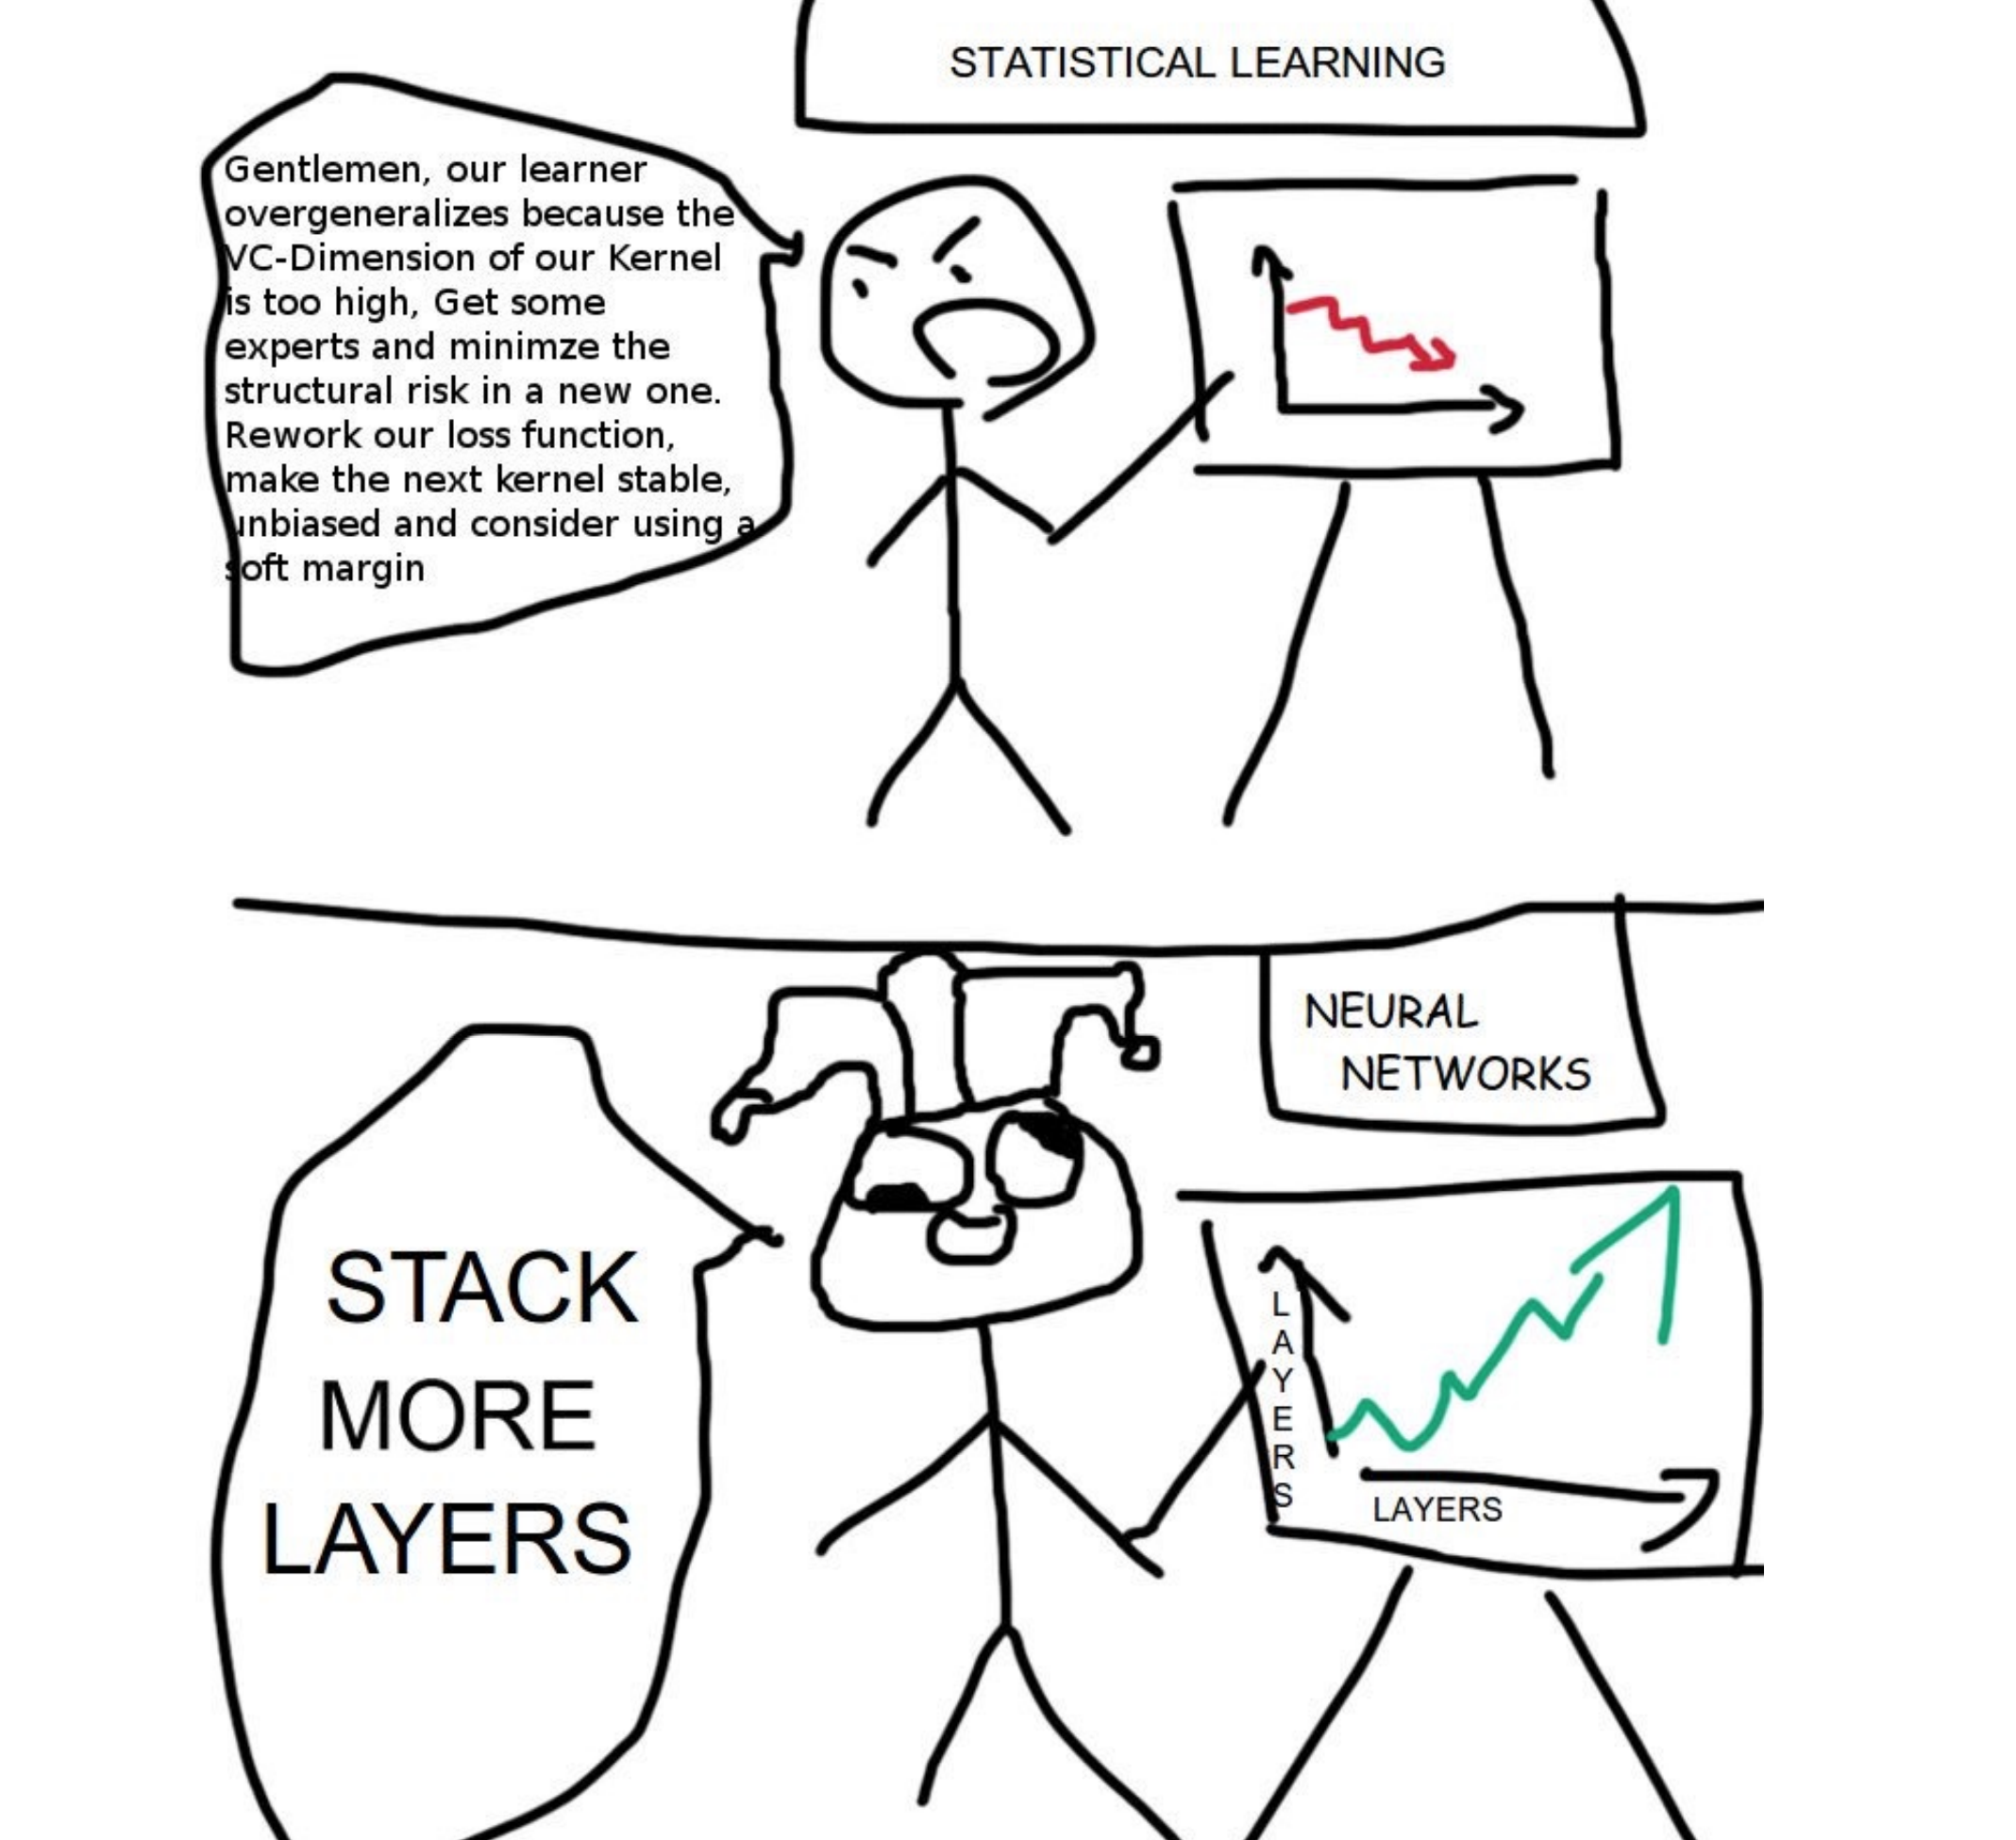

In [5]:
Image("./media/MoRe_LaYeRs.png", width=500)

Indeed, we live in a world where data is abundant but time to wait for networks just-big-enough to struggle on a local-optima-sparse gradient is not, so it's a worthwhile tradeoff -- perhaps -- to make our networks far more complex than need be... but this is not the subject of the project. Let's continue to discuss the Deep Q-Network algorithm specifically.

## Part 2.1: What to have the network approximate?

As much as we might (rightfully) hold some reservations about the above-mentioned approach of finding some approximateable function and laughing as we slap on a neural net, it is undeniable that this approach does give us quick, visible results with minimal domain-specific effort on the part of the programmer.

So what's the function we're trying to approximate here? Recall the various Q-value based algorithms where, for any action $a$ taken from a state $s$ to reach a state $s'$ granting reward $r$, the Bellman equation implies that a constraint that must hold between $Q(s,a)$ and $max_{a'}Q(s',a')$:

$$ Q(s,a) = r + \gamma * max_{a'}Q(s',a') $$

Indeed, given the Q-values of $s'$, the value $Q(s,a)$ is fixed if it wants to be optimal. Traditionally, in previous methods, we have used this constraint to compute the Q-table exactly. While these state-indexed approaches are feasible on small, discrete state spaces, they tend to struggle on large, continuous spaces. One approach is simply to squish a large number of continuous states into a smaller number of discrete states with feature functions, and another is simply to **approximate $Q(s,a)$ directly with a neural network**.

## Part 2.2: But what does it mean to approximate $Q(s,a)$?

While it is easy to say that we want to have a network predict values for $Q(s,a)$, this task is not as straightforward as most supervised ML problems.

An initial thought is that we can go the good old supervised route and, starting from terminal states, compute some ground truth Q-values before training the network on these and hoping it can generalize. But this will not work for obvious reasons. **Very few iterations and the ground truth values won't converge (they would then not properly be ground *truths*), and very many iterations and we may as well do non-neural-net Q-learning.** In other words, if we have the time to Q-iterate until convergence, we don't need a network, and if we don't have that time, training the network on non-converged Q-values will be a laughable attempt, since the model is only as good as its data (picture taken from ODSC East 2019):

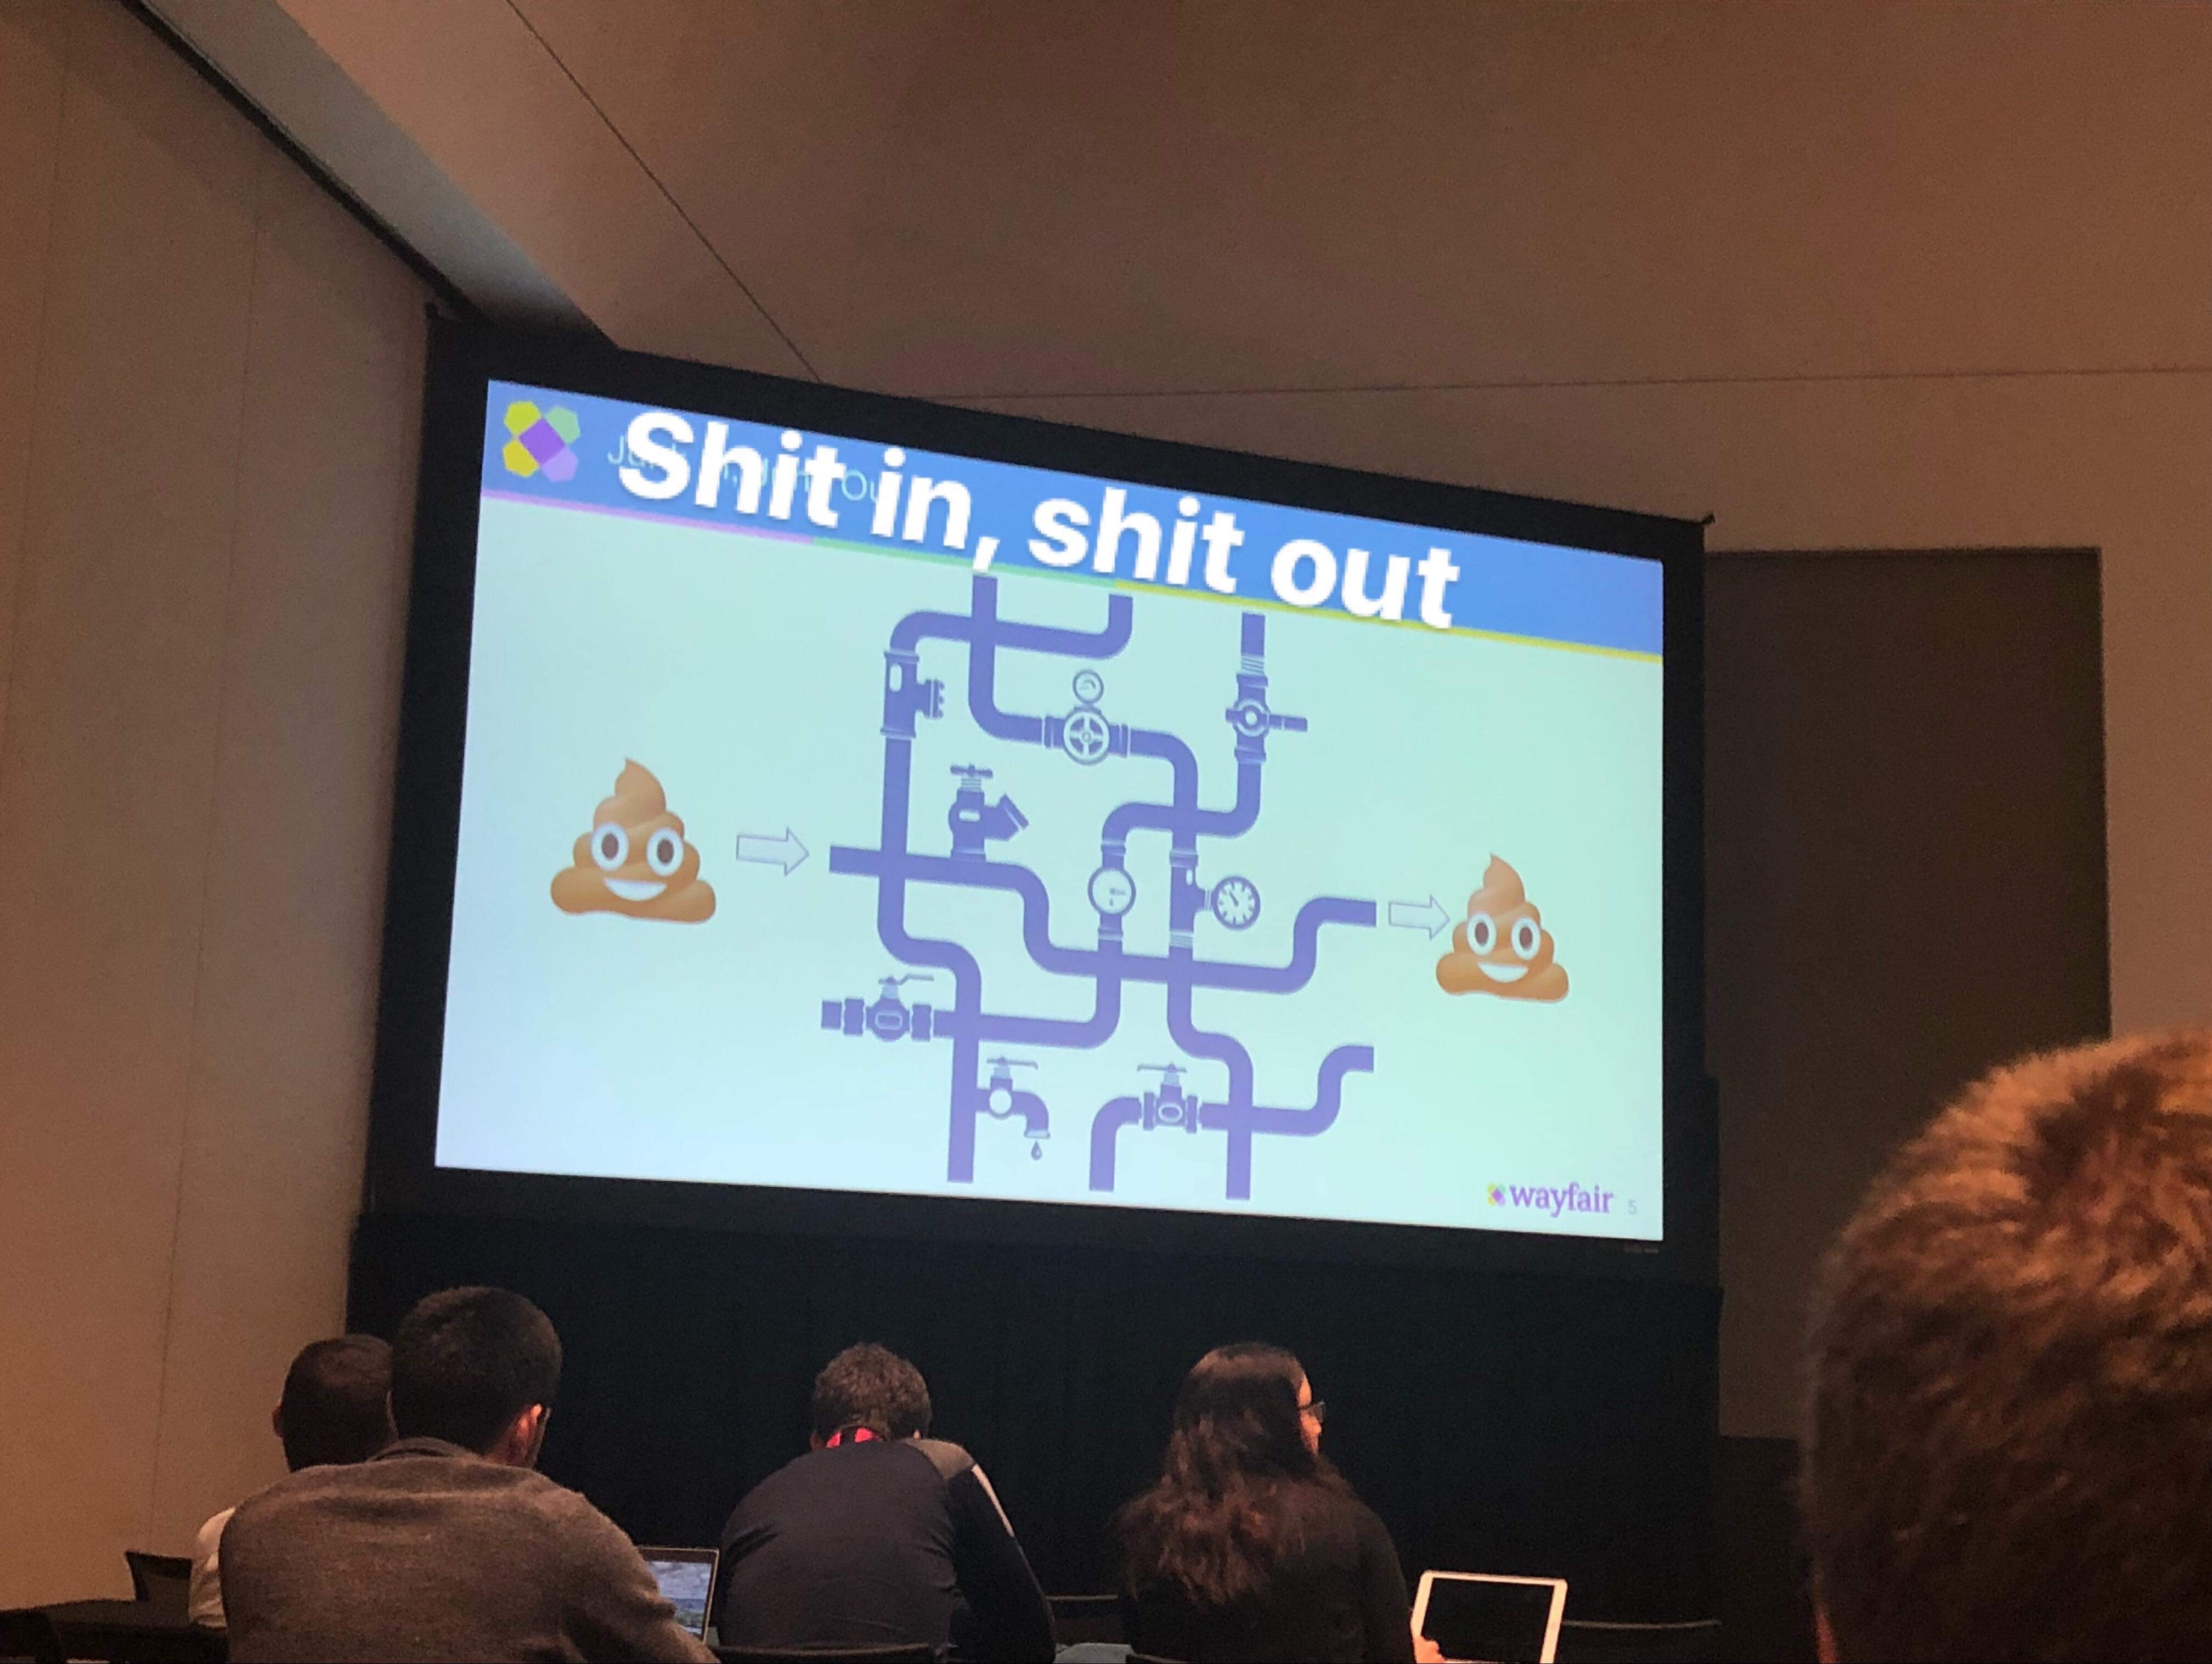

In [6]:
Image("./media/shit_in_shit_out.jpg", width=500)

All this is to say that we need to be smarter with how we design our loss, and ideally we can do it such that our agent can train *as* it gains experience and not *after*. Let's see how this can be done:

## Part 2.3: Using the Bellman equation

The answer to designing our loss lies precisely in the Bellman equation constraint shown above.

Much like Q-learning, as new experiences of the form $[s,a,r,s']$ (previous_state, action_taken, reward_recieved, next_state) come in, **we train our network to predict $Q(s,a)$ such that it is $r$ away from $\gamma$ times the max among its own predictions for the Q-values of $s'$**. Written out, this loss looks like:

$$ loss = Q(s,a) - (r + \gamma * max_{a'}Q(s',a')) $$

(Obvious in practice we should either square the loss or use something like the Huber loss, but this simple forumla gets the idea across without a lot of extra stuff.)

The advantages of this approach over supervised learning are obvious. For one, we do not need to compute any ground truth values nor wait for convergence before training as we can instead compute the loss directly as the agent gains more experience. Furthermore, using this loss also ensures that the network is explicitly incentivized to obey the Bellman equation.

Yet, this approach should also be setting off red flags... **Training a model to approximate some variant of itself is just asking for problems and lots of instability and fluctuation as it struggles to converge.**

## Part 2.4: Adding a second model

So, what can be done to alleviate this problem? As the title of this part suggests, a easy way to add more stability is simply to do a kind of more staggered training where we use two networks: a ***model_network*** and a ***target_network***.

Specifically, we use the *target_network* to compute $r + \gamma * max_{a'}Q(s',a')$ and the *model_network* to compute $Q(s,a)$. This way, we are essentially training the *model_network* to approximate some variant of the static *target_network*. Of course, every so often, we copy the weights from the *model_network* to the *target_network* so the *model_network* is still in effect approximating itself. Note that we only do gradient descent on the *model_network* and keep the *target_network* up-to-date by copying weights over. **Conceptually, this is no different from training one network to approximate its own output under the Bellman constraint, we are just doing this training in a more staggered way to improve stability**.

## Part 2.5: Using buffered experiences

Of course, when it comes to the specific implementational details, there are some other common-sense improvements that we can do.

For example, using each freshly acquired experience once to do a batch-size-one update is not only wasteful (it uses only once an experience that could otherwise be stored and reused) but also messy due to very small batches and so inaccurate gradient estimates. Furthermore, humans do not experience and forget either: we can remember our past experiences and reflect upon them to learn.

Considering all these, it is no surprise that we also implement some way of buffering experiences and sampling from what we have to train the network everytime a weight update is in order. **For this project, I implemented this as a simple wrap-around-array-queue of a fixed size where new experiences replace the oldest experiences (LRU in the buffer world) and sampling is done with uniform weight spread across everything currently in the buffer.**

## Part 2.6: Algorithm summary

And that's basically it! As Deep Q-Learning is one of the earlier techniques in RL, there are plently more literature detailing more specific improvements to the algorithm, but what was described above is essentially everything it takes for the algorithim to run decently well on small problems!

In summary, then, the key ideas involved in the Deep Q-Learning algorithm are:
* Using a neural net to approximate $Q(s,a)$ under the Bellman equation constraint.
* Using two network to train in a staggered way to decrease wild oscillations and improve stability.
* Using buffered experiences to reuse experiences and support more stable random batch training.

Now onto the specific implementation for the lunar lander game!

# Part 3: The implementation

There are two major parts to the concrete implementation:
* The pytorch network class.
* The Deep Q-Agent class.

I have taken care to thoroughly document every class and method so that additional elaboration on their functionality should not be needed.

## Part 3.1: The fully-connected network class

For the individual Deep Q-Networks, I am merely using fully-connected networks since the input data is not particularly large or complex. We are not using pixel data from the screen, but rather a feature vector compiled by `gymnasium`.

In [7]:
class FC(nn.Module):
    """
    A fully connected network.

    Attributes:
        layers -- a list of the individual fully connected network layers.

    Methods:
        __init__ -- constructor.
        forward -- forward pass.
    """
    def __init__(self, network_specification):
        """
        Constructor.
        
        Params:
            network_specification -- a list of ints representing the sizes of each layer in the network, including input and output layers.
        """
        super(FC, self).__init__()
        self.layers = nn.ParameterList()

        # build each layer
        for cur_layer_index in range(1, len(network_specification)): # skip input layer
            
            # sizes of the current and previous layers to be connected
            cur_layer_size = network_specification[cur_layer_index]
            prev_layer_size = network_specification[cur_layer_index - 1]

            # add new layer to list
            new_layer = nn.Linear(prev_layer_size, cur_layer_size)
            self.layers.append(new_layer)

    def forward(self, input):
        """
        Forward pass.

        Params:
            input -- the input vector, must be of size network_specification[0].
        Returns:
            The output of the network, will be of size network_specification[-1].
        """
        cur = input

        # pass through each hidden layer
        for hidden_layer in self.layers[:-1]:
            cur = hidden_layer(cur)
            cur = F.relu(cur)

        # pass through output layer and return
        return self.layers[-1](cur)

## Part 3.2: The Deep Q-Agent class

This class combines all the parameters ($\gamma$, $\epsilon$, etc.) with the fully-connected network objects and also functions to set up a temporary environment for training. All parameters have default values that work ok for lunar lander, but one can optionally specify any of the parameters for more control.

Different from many Deep Q-Learning implementations online, instead of a soft update on the *target_network*, I do a hard copy every fixed number of iterations. This saves a bit on computational time but mainly is, to me, conceptually cleaner (only one network is getting updated, the other is merely being brought up to date -> one moving part at a time).

In [8]:
class DeepQAgent:
    """
    A Deep-Q-Agent for the LunarLanding game.

    Attributes:
        model -- main model to approximate Q-values.
        target_model -- the model to use to compute Q-values for the next state, used for staggered training.
        
        experiences -- matrix of agent's memory of past experiences of form [previous_state, action_taken, reward_recieved, next_state].
        max_experience_capacity -- int, the max number of experiences to store at once.
        experience_counter -- int, total number of experiences ever, use experience_counter % max_experience_capacity to get index.
        
        epsilon -- 0-1, for epsilon-greedy.
        gamma -- 0-1, for reward discounting.
        update_every -- number of actions to take in environment before updating model parameters.
        delayed_update_every -- number of actions to take in environment before copying weights from self.model to self.target_model.

        FC_loss_function -- loss function into which to pass difference between self.model output and Bellman-ed self.target_model output.
        FC_optimizer -- optimizer for FC network.
        FC_batch_size -- batch size to use for FC training.
        FC_learning_rate -- learnining rate for FC training.
        
    Methods:
        __init__ -- constructor.
        choose_informed_action -- greedily compute action choice using Q-value predictions from self.model.
        remember_experience -- add an experience of form [previous_state, action_taken, reward_recieved, next_state] to self.experiences.
        update_weights_batch -- update the FC weights by sampling from self.experiences, helper for self.train.
        train -- main training function of agent.
    """
    
    def __init__(self,
                 FC_specification=[STATE_SPACE_SIZE, 128, 128, ACTION_SPACE_SIZE],
                 max_experience_capacity=1000,
                 epsilon=0.1,
                 gamma=0.99,
                 update_every=5,
                 delayed_update_every=100,
                 FC_batch_size=128,
                 FC_learning_rate=0.0001):
        """
        Constructor.

        Params:
            FC_specification -- the specifications of self.model and self.target_model.
            max_experience_capacity -- int, the max number of experiences to store at once.
            epsilon -- 0-1, for epsilon-greedy.
            gamma -- 0-1, for reward discounting.
            update_every -- number of actions to take in environment before updating model parameters.
            delayed_update_every -- number of actions to take in environment before copying weights from self.model to self.target_model.
            FC_batch_size -- batch size to use for FC training.
            FC_learning_rate -- learnining rate for FC training.
        """
        # initialize model attributes
        self.model = FC(FC_specification)
        self.target_model = FC(FC_specification)
        self.target_model.load_state_dict(self.model.state_dict())

        # initialize experience attributes
        self.experiences = np.zeros((max_experience_capacity, STATE_SPACE_SIZE*2+2)) # two states, one action, and one reward
        self.max_experience_capacity = max_experience_capacity
        self.experience_counter = 0

        # initialize agent params
        self.epsilon = epsilon
        self.gamma = gamma
        self.update_every = update_every
        self.delayed_update_every = delayed_update_every

        # initialize FC params
        self.FC_loss_function = nn.SmoothL1Loss()
        self.FC_optimizer = torch.optim.AdamW(self.model.parameters(), lr=FC_learning_rate)
        self.FC_batch_size = FC_batch_size
        self.FC_learning_rate = FC_learning_rate
        return

    def choose_informed_action(self, obs, use_epsilon=False):
        """
        Greedily compute action choice using Q-value predictions from self.model.

        Params:
            obs -- array, the input observation.
            use_epsilon -- bool, whether to act randomly for exploration with probability self.epsilon, turn on in training off in testing.
        Returns:
            An int representing the action to take.
        """
        # reshape obs to put into network
        obs = torch.unsqueeze(torch.FloatTensor(obs),0)

        # predict Q-values
        q_values = self.model.forward(obs)

        # return the action with the highest Q-value
        return torch.max(q_values, dim=1)[1].item()
        
    def remember_experience(self, s, a, r, s_):
        """
        Add an experience of form [previous_state, action_taken, reward_recieved, next_state] to self.experiences.
        NOTE: Overrides old experiences if self.max_experience_capacity has been reached.
        
        Params:
            s -- previous state.
            a -- action taken to get to next state.
            r -- reward recieved as a result of action a.
            s_ -- next state.
        Returns:
            None.
        Side effects:
            Updates self.experiences and self.experience_counter.
        """
        # build the experience vector
        experience = np.concatenate((s,[a,r],s_))
        
        # store experience in self.experiences
        index = self.experience_counter % self.max_experience_capacity
        self.experiences[index,:] = experience

        # update counter
        self.experience_counter += 1
        return

    def update_weights_batch(self):
        """
        Update the FC weights by sampling from self.experiences, helper for self.train.
        
        Params:
            None.
        Returns:
            None.
        Side effects:
            Modifies self.model.
        """
        # sample FC_batch_size number of experiences from self.experiences
        indicies = np.random.choice(self.max_experience_capacity, self.FC_batch_size)
        batch = self.experiences[indicies,:]

        # split out the batch of experiences into [previous_state, action_taken, reward_recieved, next_state]
        s = torch.FloatTensor(batch[:, :STATE_SPACE_SIZE])
        a = torch.LongTensor(batch[:, STATE_SPACE_SIZE:STATE_SPACE_SIZE+1])
        r = torch.FloatTensor(batch[:, STATE_SPACE_SIZE+1:STATE_SPACE_SIZE+2])
        s_ = torch.FloatTensor(batch[:, -STATE_SPACE_SIZE:])

        # get Q-values
        q_value_for_s_a = self.model.forward(s).gather(1, a)
        all_q_values_for_s_ = self.target_model.forward(s_).detach() # detach so we do not train target network

        # implement Bellman equation to get target Q-value
        q_target = r + self.gamma*all_q_values_for_s_.max(1)[0].view(self.FC_batch_size, 1)

        # compute loss and backprop
        loss = self.FC_loss_function(q_value_for_s_a, q_target)
        self.FC_optimizer.zero_grad()
        loss.backward()
        self.FC_optimizer.step()

    def train(self, num_episodes, verbose_interval=None):
        """
        Main training function of agent.

        Params:
            num_episodes -- int, number of games to play in this training session
            verbose_interval -- int or None, the interval at which to print score statistics, set to None for not verbose
        Returns:
            None
        Side effects:
            Modifies self.model and self.target_model.
        """
        # setup a temporary environment for training
        env = gym.make(ENVIRONMENT)
        episode_scores = []
        
        # run through each episode
        for episode_number in range(1, num_episodes+1):

            # setup episode
            cur_obs, info = env.reset()
            episode_score = 0

            # run through each step
            for _ in range(1000):

                # get epsilon greedy action and take step
                action = env.action_space.sample() if np.random.uniform() < self.epsilon else self.choose_informed_action(cur_obs)
                new_obs, reward, is_complete, is_truncated, info = env.step(action)

                # remember the experience
                self.remember_experience(cur_obs, action, reward, new_obs) # increments self.experience_counter

                # as soon as self.experiences is full, start learning at each new experience addition at interval self.update_every
                if self.experience_counter % self.update_every == 0 and self.experience_counter >= self.max_experience_capacity:
                    self.update_weights_batch()

                # as soon as self.experiences is full, start copying self.model to self.target_model at interval self.delayed_update_every
                if self.experience_counter % self.delayed_update_every == 0 and self.experience_counter >= self.max_experience_capacity:
                    self.target_model.load_state_dict(self.model.state_dict())

                # maintainance
                cur_obs = new_obs
                episode_score += reward
                if is_complete or is_truncated: break
                    
            # finished episode -> update episode_scores and maybe print score statistics
            episode_scores.append(episode_score)
            if verbose_interval is not None and episode_number % verbose_interval == 0:
                episode_scores = np.array(episode_scores)
                print(f"Finished episode {episode_number}.")
                print(f"\tMedian score for the last {verbose_interval} episodes is {np.median(episode_scores)}.")
                print(f"\tMax score for the last {verbose_interval} episodes is {np.max(episode_scores)}.")
                print(f"\tMin score for the last {verbose_interval} episodes is {np.min(episode_scores)}.")
                print(f"\tStd for the last {verbose_interval} episodes is {episode_scores.std()}.")
                episode_scores = []

        # finished all episodes -> close env and print message
        env.close()
        print(f"Finished training {num_episodes} episodes.")
        return

# Part 4: Training and results

In this part we will put the above classes to use and actually train an agent to land spacecrafts!

## Part 4.1: Initializing a random agent

We will create an agent with default parameters (NOTE: I did some very, very primitive eye-ball tuning on the default values so that they work, additional tuning will certainly improve results):

In [9]:
agent = DeepQAgent()

At initialization, the agent is essentially random, and should be expected to perform as badly as a random agent:

In [10]:
play_games(num_episodes=50, agent=agent, see_games=False)

Statistics over 50 episodes:
	Median score: -564.6067907537688
	Max score: -301.7900248645583
	Min score: -802.7085884820262
	Score std: 128.97457637467585



Indeed it does... now let's train it.

## Part 4.2: First round of training

Let's begin by training it with 500 episodes, printing out aggregate stats every 100 episodes:

In [11]:
agent.train(num_episodes=500, verbose_interval=100)

Finished episode 100.
	Median score for the last 100 episodes is -268.4112228435049.
	Max score for the last 100 episodes is -80.29730729221008.
	Min score for the last 100 episodes is -1273.3835610897597.
	Std for the last 100 episodes is 204.64483264785707.
Finished episode 200.
	Median score for the last 100 episodes is -76.51820858929582.
	Max score for the last 100 episodes is 235.6428785511514.
	Min score for the last 100 episodes is -312.9987714627561.
	Std for the last 100 episodes is 86.2341314365568.
Finished episode 300.
	Median score for the last 100 episodes is -15.309204452111139.
	Max score for the last 100 episodes is 275.06969134341875.
	Min score for the last 100 episodes is -246.82146628055727.
	Std for the last 100 episodes is 118.81313604049053.
Finished episode 400.
	Median score for the last 100 episodes is -38.84107291525004.
	Max score for the last 100 episodes is 291.38791001463346.
	Min score for the last 100 episodes is -265.8070217528212.
	Std for the last 

What does the agent look like now?

In [12]:
play_games(num_episodes=2, agent=agent, see_games=True)

Statistics over 2 episodes:
	Median score: 131.7876923093379
	Max score: 192.68810974365675
	Min score: 70.88727487501905
	Score std: 60.900417434318854



It still has a long way to go... but it has already learned the basics of maintaining control in the air. Next let's train it some more.

## Part 4.3: Second round of training

Another 900 episodes:

In [13]:
agent.train(num_episodes=900, verbose_interval=100)

Finished episode 100.
	Median score for the last 100 episodes is 126.38161250548912.
	Max score for the last 100 episodes is 297.2657507290852.
	Min score for the last 100 episodes is -155.89463165005722.
	Std for the last 100 episodes is 130.69513259637554.
Finished episode 200.
	Median score for the last 100 episodes is 210.99670136493964.
	Max score for the last 100 episodes is 288.81696794110985.
	Min score for the last 100 episodes is -127.99804743428534.
	Std for the last 100 episodes is 111.42723062744845.
Finished episode 300.
	Median score for the last 100 episodes is 209.4331290454956.
	Max score for the last 100 episodes is 301.3092473691722.
	Min score for the last 100 episodes is -142.32186075231627.
	Std for the last 100 episodes is 101.36924965948458.
Finished episode 400.
	Median score for the last 100 episodes is 199.20161785133888.
	Max score for the last 100 episodes is 297.8860719439334.
	Min score for the last 100 episodes is -162.937558338839.
	Std for the last 10

How did it do?

In [14]:
play_games(num_episodes=50, agent=agent, see_games=False)

Statistics over 50 episodes:
	Median score: 220.20302086043097
	Max score: 288.17376900650197
	Min score: 129.79585859816868
	Score std: 42.57514933299059



Very good on average! Let's take a closer look:

In [15]:
play_games(num_episodes=2, agent=agent, see_games=True)

Statistics over 2 episodes:
	Median score: 192.38936892127012
	Max score: 233.55469045622948
	Min score: 151.22404738631076
	Score std: 41.16532153495936



Overall the performance is very satisfactory and the variance is low! This is mainly thanks to a lower learning rate and the various techniques discussed above that improve training stability.

Now we have a fully trained agent that can land spacecrafts!

# Part 5: Interactive example

This space can be used to mess around using the classes above. In the example code below, an agent is created with default hyperparameters and trained for 100 iterations (which isn't enough for it to do well given the low learning rate), one can experiment with the hyperparams or use different training regimens to help it do better.

Below are a couple notes on the hyperparams:
* Training Deep Q-Networks is already a noisy process! The least we can do is to decrease the `FC_learning_rate` (learning rate for the fully connected network). I would not recommend increasing it beyond the default value as, in my experience, doing so leads to significantly higher variance and more episodes with large negative scores. Obviously, changing the learning rate should also be accompanied by changes to the total number of iterations trained.
* `FC_batch_size` does not affect the number of updates per epoch since there is no real concept of an "epoch" here as there is in supervised learning. Do not decrease this just to make the model do more updates (in fact higher batch sizes will get us better gradient estimates and make the network reuse more data), instead directly decrease `update_every` and `delayed_update_every` for more frequent weight updates. If you do tune `FC_batch_size` make sure also to consider changing `max_experience_capacity` so the same proportion of experiences are used for every update.
* `gamma` and `epsilon` have large effects on training and too large/too small values can make the agent do much worse! Tune these at smaller intervals and with caution.

Have fun!

In [16]:
# create agent
interactive_agent = DeepQAgent(FC_specification=[STATE_SPACE_SIZE, 128, 128, ACTION_SPACE_SIZE],
                               max_experience_capacity=1000,
                               epsilon=0.1,
                               gamma=0.99,
                               update_every=5,
                               delayed_update_every=100,
                               FC_batch_size=64,
                               FC_learning_rate=0.0001)

# train silently for 25 episodes
interactive_agent.train(num_episodes=50, verbose_interval=None)

# train silently for another 25 episodes
interactive_agent.train(num_episodes=50, verbose_interval=None)

# display the (terrible) results, change the code to make these better!
play_games(num_episodes=10, agent=interactive_agent, see_games=False)

Finished training 50 episodes.
Finished training 50 episodes.
Statistics over 10 episodes:
	Median score: -25.35804696037892
	Max score: 183.39582726904536
	Min score: -210.60214686276458
	Score std: 149.67705320001156

